This notebook illustrates a problem related to errors in Landsat 7 images which probably occurrs due to oversaturation or due to some other processing errors. This error is not observed in Landsat 8 or other image collections.

The error can be easily fixed when working with raw DN values, but it becomes much more difficult to clean these errors once DN radiance values are converted into reflectance values.

In [1]:
%matplotlib inline

import math

import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf

import matplotlib.pyplot as plt

import ee

ee.Initialize()

Define functions to compute reflectance manually using image parameters, get values, and plot them

In [2]:
def to_rad(deg):
    return deg.multiply(math.pi).divide(180)
  
def from_dn(image, fix):
    dn = image
    
    if (fix):
        dn = dn.updateMask(dn.neq(255))
    
    factor = to_rad(ee.Number(image.get('SUN_ELEVATION'))).sin()
  
    gain2 = ee.Number(image.get('REFLECTANCE_MULT_BAND_2')).divide(factor)
    bias2 = ee.Number(image.get('REFLECTANCE_ADD_BAND_2')).divide(factor)
    gain5 = ee.Number(image.get('REFLECTANCE_MULT_BAND_5')).divide(factor)
    bias5 = ee.Number(image.get('REFLECTANCE_ADD_BAND_5')).divide(factor)
    
    return dn.multiply(ee.Image([gain2, gain5])).add(ee.Image([bias2, bias5]))

def get_values(image, region):
    values = ee.ImageCollection(image).getRegion(region, 30).getInfo()
    
    return pd.DataFrame(values[1:], columns=values[0])

def plot_values(data_frame):
    canvas = ds.Canvas(plot_width=200, plot_height=200, x_range=(0, 0.5), y_range=(0, 0.5))
    agg = canvas.points(data_frame, 'B2', 'B5')
    
    return tf.shade(agg, cmap=['lightblue', 'darkblue'], how='eq_hist')

Define area of intereset and image collection (Landsat 7 T1 collection)

In [3]:
# defind area of interest
aoi = ee.Geometry.Point([-64.15328979492182, 11.37368511744568]).buffer(3000)

# get a few Landsat 7 images
images = ee.ImageCollection('LANDSAT/LE07/C01/T1') \
    .filterDate('2017-01-01', '2018-01-01') \
    .filterBounds(aoi) \
    .select(['B2', 'B5'])

In [4]:
# get a single image
image = ee.Image(images.first())

# compute reflectance
reflectance_fix = from_dn(image, True)
reflectance_nofix = from_dn(image, False)

# get values
data_nofix = get_values(reflectance_nofix, aoi)
data_fix = get_values(reflectance_fix, aoi)

Without removing 255, the resulting reflectance values generate spikes and this becomes a real problem, since then can't be removed anymore without using some special filtering. With a multitemporal analysis, this generates many spikes.

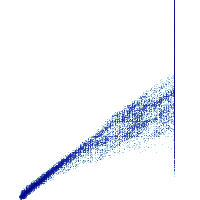

In [5]:
plot_values(data_nofix)

A simple fix (masking out DN=255) results in a clean reflectance plot

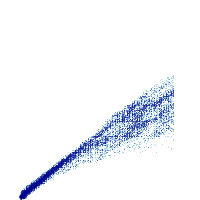

In [6]:
plot_values(data_fix)

Plot reflectance values without the oversaturation fix for 15 images, this takes a bit more time to generate

In [7]:
# convert multiple images to reflectance
reflectance_nofix_multiple = images.limit(15).map(lambda i: from_dn(i, False))

# get values
data_nofix_multiple = get_values(reflectance_nofix_multiple, aoi)

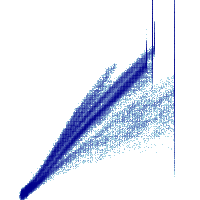

In [8]:
# plot
plot_values(data_nofix_multiple)